In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
with open('../input/passenger-dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air-passengers.csv.gz', **read_csv_opts)

In [3]:
pickups = df['PULOC'] == 'KBFI'
dropoffs = df['DropLoc'] == 'KBFI'
kbfi = df.loc[pickups | dropoffs]

In [4]:
kbfi.set_index('MissionDate', inplace=True)

In [5]:
kbfi = kbfi['2018-10-01':]

In [6]:
del df

In [19]:
# kykm = pd.read_csv('../input/ICEAirKYKM20191016.csv', header=1)
kykm = pd.read_csv('../input/ICEAirKYKM20191226.csv', header=1)

In [20]:
kykm.columns

Index(['Date', 'Flight count', 'Flight number', 'Tail number', 'Operator',
       'Owner', 'Previous Airport', 'Next Airport',
       'From NWDC - Boarded Plane', 'From Plane - Boarded Bus to NWDC',
       'From NWDC - Boarded Plane.1', 'From Plane - Boarded Bus to NWDC.1',
       'Snoq Pass', 'White Pass', '# Buses', 'Observations', 'Link'],
      dtype='object')

In [21]:
kykm = kykm.drop(['From NWDC - Boarded Plane.1', 'From Plane - Boarded Bus to NWDC.1'], axis=1)

In [22]:
kykm = kykm.rename({'From NWDC - Boarded Plane': 'Pickups', 'From Plane - Boarded Bus to NWDC': 'Dropoffs'}, axis=1)

In [25]:
kykm = kykm.drop(range(45, len(kykm)))

In [26]:
kykm['Date'] = pd.to_datetime(kykm['Date'])

In [27]:
kykm.set_index('Date', inplace=True)

In [28]:
kykm = kykm[['Pickups', 'Dropoffs']]

In [29]:
kykm['Airport'] = 'KYKM'

In [30]:
kykm.loc[:,['Pickups', 'Dropoffs']] = kykm[['Pickups', 'Dropoffs']].replace('-', np.nan)

In [31]:
kykm.loc[:,['Pickups', 'Dropoffs']] = kykm.loc[:,['Pickups', 'Dropoffs']].astype(float)

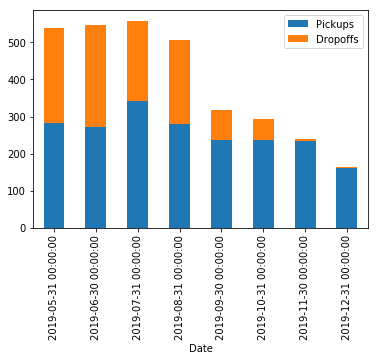

In [33]:
kykm.resample('M')[['Pickups', 'Dropoffs']].sum().plot(kind='bar', stacked=True);

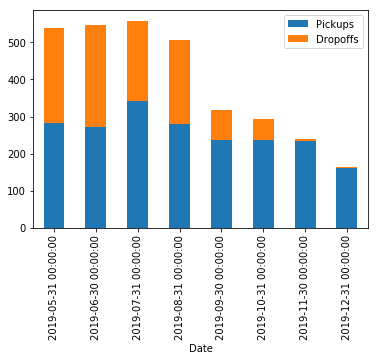

In [34]:
kykm.resample('M')[['Pickups', 'Dropoffs']].sum().plot(kind='bar', stacked=True);

In [35]:
pickups = kbfi['PULOC'] == 'KBFI'
dropoffs = kbfi['DropLoc'] == 'KBFI'

In [36]:
d = {'Pickups': kbfi[pickups].resample('D').size(), 'Dropoffs': kbfi[dropoffs].resample('D').size()}

In [37]:
kbfi = pd.DataFrame(d)
kbfi = kbfi[(kbfi.T != 0).any()]

In [38]:
kbfi['Airport'] = 'KBFI'

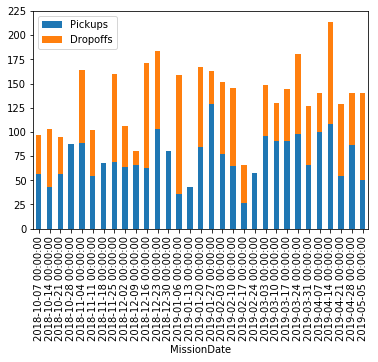

In [39]:
kbfi.resample('W')[['Pickups', 'Dropoffs']].sum().plot(kind='bar', stacked=True);

In [46]:
temp = pd.concat([kbfi, kykm])

In [47]:
temp = temp.fillna(0)

In [48]:
temp = temp['2019-1-01':]

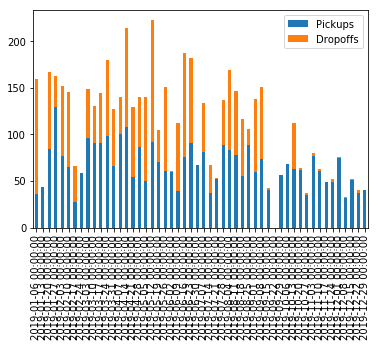

In [51]:
temp.resample('W')[['Pickups', 'Dropoffs']].sum().plot(kind='bar', stacked=True);

In [52]:
data = temp.resample('M')[['Pickups', 'Dropoffs']].sum()

In [53]:
data.index = data.index.month_name().str[0:3]

In [78]:
def bar_chart(data, airport=str, airport_name=str, filename=str, title=str):
    fig, ax = plt.subplots()
    
    # FY shading
#     ax.axvspan(-2, 6.5, facecolor='g', alpha=0.1)
#     ax.axvspan(6.5, 14, facecolor='y', alpha=0.1)
    
    # CY shading
    ax.axvspan(-2, 4.5, facecolor='g', alpha=0.1)
    ax.axvspan(4.5, 14, facecolor='y', alpha=0.1)
    
    data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              grid=True,
              figsize=(8,6),
              fontsize=14,
#               color=['g','y'],
              alpha=1)
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
#     ax.set_xlabel('Month, FY19', fontsize=16)

    ax.set_title(f'{title}', fontsize=18)
    ax.tick_params(labelsize=14, labelrotation=0)
    

    
    ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right', fontsize=14)
    
    plt.figtext(.225, .825, 'KBFI (ICE data)', horizontalalignment='center', fontsize=16)
    plt.figtext(.75, .825, 'KYKM (YIRN obs.)', horizontalalignment='center', fontsize=16)
    
    txt='(Observations missing for 1 flight in Sep. 2019)'
    plt.figtext(0.7, .02, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
#     fig.savefig(f'../output/{airport}_{filename}.png')
    plt.show()
    plt.close()

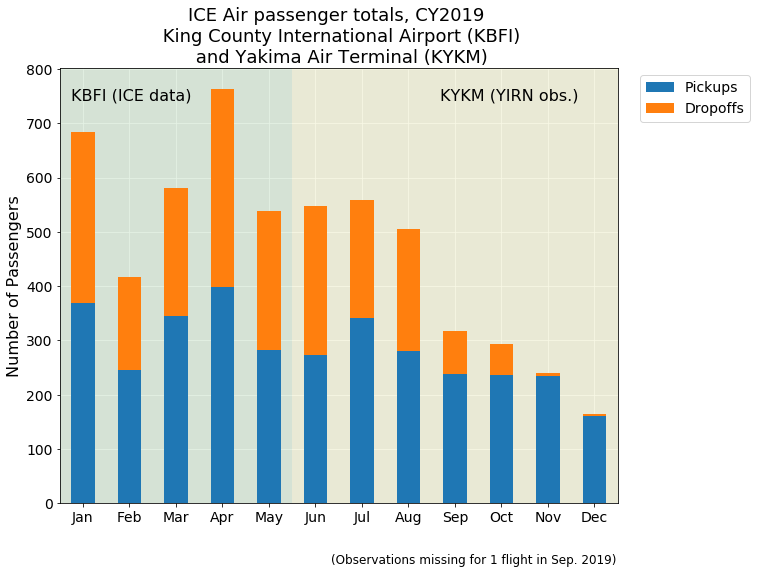

In [79]:
title = 'ICE Air passenger totals, CY2019 \n King County International Airport (KBFI)\n and Yakima Air Terminal (KYKM)'
bar_chart(data, title=title)

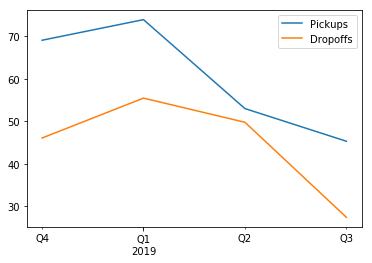

In [395]:
temp[:'2019-9-30'].groupby([pd.Grouper(freq='Q')]).mean().plot()